In [1]:
# Spindle detection, inspired by "Characterizing sleep spindles in 11,630 individuals from the 
# National Sleep Research Resource", S. M. Purcell et al, 2017.

In [2]:
import csv
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy.signal as signal
import seeg_library as slib
import seeg_constants as CONST
import mne
from matplotlib.colors import Normalize, LogNorm
import pywt
from scipy import ndimage

In [3]:
# Get data
patient = "p1"
p_num = patient[1:]
root = "C:\\Users\\amand\\Documents\\Research\\Project_AHN\\Data_processing\\data\\meditation_sleep\\"
path = root + patient + "\\M" + p_num + "_Sleep.edf"

data = mne.io.read_raw_edf(path, preload=True)
channels = slib.create_channel_dict(data.ch_names)
print(channels)
print(data.info)

raw_data = data.get_data()

Extracting EDF parameters from C:\Users\amand\Documents\Research\Project_AHN\Data_processing\data\meditation_sleep\p1\M1_Sleep.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3649023  =      0.000 ...  3563.499 secs...
{'O1': 0, 'O2': 1, 'O3': 2, 'O4': 3, 'O5': 4, 'O6': 5, 'O7': 6, 'O8': 7, 'O9': 8, 'O10': 9, 'O11': 10, 'O12': 11, 'Y1': 12, 'Y2': 13, 'Y3': 14, 'Y4': 15, 'Y5': 16, 'Y6': 17, 'Y7': 18, 'Y8': 19, 'Y9': 20, 'Y10': 21, 'Y11': 22, 'Y12': 23, 'Y13': 24, 'Y14': 25, 'G1': 26, 'G2': 27, 'G3': 28, 'G4': 29, 'G5': 30, 'G6': 31, 'G7': 32, 'G8': 33, 'G9': 34, 'G10': 35, 'G11': 36, 'G12': 37, 'T1': 38, 'T2': 39, 'T3': 40, 'T4': 41, 'I1': 42, 'I2': 43, 'I3': 44, 'I4': 45, 'I5': 46, 'I6': 47, 'I7': 48, 'I8': 49, 'A1': 50, 'A2': 51, 'A3': 52, 'A4': 53, 'A5': 54, 'A6': 55, 'A7': 56, 'A8': 57, 'A9': 58, 'A10': 59, 'B1': 60, 'B2': 61, 'B3': 62, 'B4': 63, 'B5': 64, 'B6': 65, 'B7': 66, 'B8': 67, 'B9': 68, 'B10': 69, 'C1': 70, 'C2': 71, '

In [4]:
fs = 1024
offset = 400000  # Get past bad recording sections

In [83]:
# Pick channel ch
ch_name = "G1"
ch = raw_data[channels[ch_name], :]

In [84]:
# Subsample by selecting every n
n_subsamp = 4  # Subsample by selecting every n
ch = ch[0::n_subsamp]

# Adjust parameters
Fs = fs / n_subsamp
Offset = int(offset / n_subsamp)

ch = slib.band_noise_filter(ch)
# ch = mne.filter.filter_data(ch, fs, 8, 20)
print(ch.shape)

(912256,)


In [85]:
# Set timing parameters
# NOTE: 96000 and 156000 is a good range for many spindles
debut = 200000  # NOTE: these are in absolute time, not after subsampling
fin = 300000
i1 = int(debut / n_subsamp)
i2 = int(fin / n_subsamp)

# Set wavelet parameters
wavelet = 'cmor0.025-10'
widths = np.arange(10, 256)

In [86]:
# Do the transform
cwtmatr, freqs = pywt.cwt(ch[Offset+i1:Offset+i2], widths, wavelet, 1/Fs)
print(np.max(freqs), np.min(freqs))
print(cwtmatr.shape)

256.0 10.03921568627451
(246, 25000)


In [87]:
# Select window for spindle coefficients (wrt power)
lower_f = 10
upper_f = 14
spindle_rng = np.where((freqs > lower_f) & (freqs < upper_f))[0]
power = cwtmatr.real**2 + cwtmatr.imag**2
spindle_coef = power[spindle_rng, :]
recording_av = np.mean(spindle_coef, axis=1)
print(power.shape)

(246, 25000)


In [88]:
# Smooth coefficients with moving average
ma_window = 0.1  # moving average duration in (s)
n_ma = int(Fs * ma_window)
min_width = 0.3  # minimum width to consider a spindle event (in s)

# Detect spindle events
for f in range(spindle_coef.shape[0]):
    spindle_coef_new = np.convolve(spindle_coef[f, :], np.ones(n_ma)/n_ma, mode='valid')
    spindle = np.where(spindle_coef_new > 4*recording_av[f])[0]
    diffr = np.diff(spindle)
    cutoff = np.where(diffr > 128)[0]
    idx_seg = np.append(np.insert(spindle[cutoff], 0, spindle[0]), spindle[-1])
    n_seg = len(cutoff)  # Find number of distinct segments
    if f == 30:
        print("Selected frequency is " + str(freqs[spindle_rng[f]]))
        arr = []
    for j in range(n_seg):
        if j == 0:
            head = spindle[0]
        else:
            head = spindle[cutoff[j-1]+1]
        tail = spindle[cutoff[j]]
        if f == 30 and tail-head > 75:
            arr.append((head, tail))
print(arr)

Selected frequency is 12.018779342723004
[(234, 325), (1001, 1218), (5517, 5607), (6223, 6661), (7455, 7604), (8283, 8579), (12714, 12807), (16493, 16678)]


0.9140625 1.26953125
3.91015625 4.7578125
21.55078125 21.90234375
24.30859375 26.01953125
29.12109375 29.703125
32.35546875 33.51171875
49.6640625 50.02734375
64.42578125 65.1484375


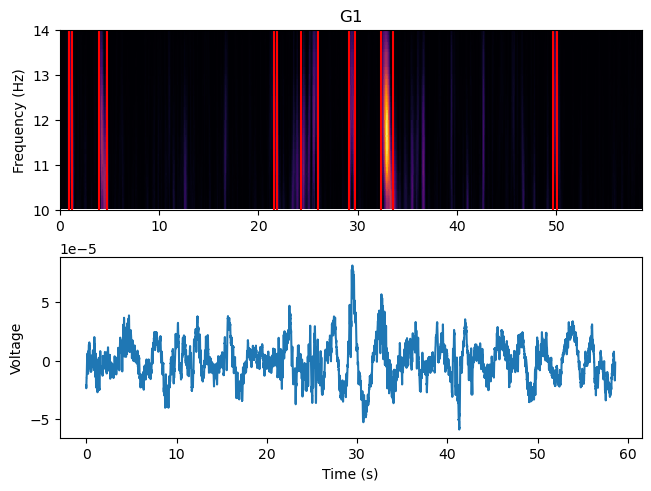

In [89]:
# Plot spectrograms (or scaleogram?)
step = 15000
start = 0
stop = 15000
p1_arr = np.arange(start, stop, step)
p2_arr = p1_arr + step

dt = 1.0 / Fs

for i in range(len(p1_arr)):
    p1 = p1_arr[i]
    p2 = p2_arr[i]
    fig, axs = plt.subplots(2, 1, layout='constrained')
    
    power = cwtmatr[:, p1:p2].real**2 + cwtmatr[:, p1:p2].imag**2
    times = (np.arange(power.shape[1])+start) * dt

    im = axs[0].pcolormesh(times, freqs, power, vmin=0, cmap="inferno")
    axs[0].set_ylim(lower_f, upper_f)
    # Plot detected spindle boundaries
    if i == 0:
        for j in range(len(arr)):
            head = arr[j][0]*dt
            tail = arr[j][1]*dt
            print(head, tail)
            if tail < times[-1] and head > times[0]:
                axs[0].plot([head, head], [lower_f, upper_f], 'r')
                axs[0].plot([tail, tail], [lower_f, upper_f], 'r')
    # Plot time series
    tseries = axs[1].plot(times, ch[Offset+i1+p1:Offset+i1+p2])
    
    # Set labels
    axs[1].set_xlabel("Time (s)")
    axs[0].set_ylabel("Frequency (Hz)")
    axs[1].set_ylabel("Voltage")
    axs[0].set_title(ch_name)
plt.savefig("M1_G1_testseg.png")